In [1]:
INPUT_IMAGE = "ghscreenshot.png"
TEMP_OUTPUT_NAME="temp.jpg"
IMAGES_DIR='out_images'
OUTPUT_FILE='test.md'

In [2]:
# for the DiT part
import cv2

from object_detection.ditod import add_vit_config

import torch
from time import time

from detectron2.config import get_cfg
from detectron2.utils.visualizer import ColorMode, Visualizer
from detectron2.data import MetadataCatalog
from detectron2.engine import DefaultPredictor


# for the tesseract part
import matplotlib.pyplot as plt
from subprocess import check_output
import pandas as pd
import subprocess



In [3]:
torch.cuda.is_available()

True

In [4]:
# Step 1: instantiate config
cfg = get_cfg()
add_vit_config(cfg)
cfg.merge_from_file("./object_detection/publaynet_configs/maskrcnn/maskrcnn_dit_base.yaml")

# Step 2: add model weights URL to config
cfg.merge_from_list(["MODEL.WEIGHTS","./model_final.pth"])

# Step 3: set device
device = "cuda" if torch.cuda.is_available() else "cpu"
cfg.MODEL.DEVICE = device

# Step 4: define model
predictor = DefaultPredictor(cfg)


In [5]:
# Step 5: run inference
img = cv2.imread(INPUT_IMAGE)

md = MetadataCatalog.get(cfg.DATASETS.TEST[0])
md.set(thing_classes=["text","h1","code","ul","figure", "ol", "h2", "h3", "h4", "h5", "h6"])



namespace(name='custom_eval',
          thing_classes=['text',
                         'h1',
                         'code',
                         'ul',
                         'figure',
                         'ol',
                         'h2',
                         'h3',
                         'h4',
                         'h5',
                         'h6'])

In [6]:
t = time()
output = predictor(img)["instances"]
print(time()-t)

# filter data by confidence
output = output[output.scores > 0.5]

print(output.pred_boxes)
print(output.pred_classes)
print(output.scores)


: 

: 

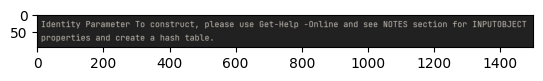

Identity Parameter To construct, please use Get-Help -Online and see NOTES section for INPUTOBJECT
properties and create a hash table.



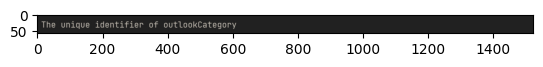

The unique identifier of outlookCategory



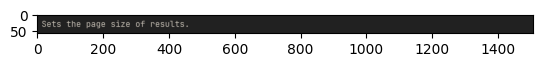

Sets the page size of results.



In [9]:
from os import path, makedirs

# get text detections

text = output[output.pred_classes == 0]

txt = ""

# for each, save them and run tesseract on them
for i in range(output.pred_classes.shape[0]):
    bbs = output.pred_boxes[i].tensor[0].int()
    cropped = img[bbs[1]:bbs[3],bbs[0]:bbs[2]]
    
    out = ""

    # run tesseract if it isn't a figure
    if output.pred_classes[i] != 4:
        cv2.imwrite(TEMP_OUTPUT_NAME, cropped)
        out = check_output(['tesseract', TEMP_OUTPUT_NAME, "-", "-l", "eng"], stderr=subprocess.DEVNULL).decode('utf-8')
    
    if output.pred_classes[i] == 0:
        txt += out
    elif output.pred_classes[i] == 1:
        txt += '# '+ out
    elif output.pred_classes[i] == 2:
        txt += '```'
        txt += out
        txt += '```'
    elif output.pred_classes[i] == 3:
        for el in out.splitlines():
            txt+='* ' + el
    elif output.pred_classes[i] == 4:
        if not path.exists(IMAGES_DIR):
            makedirs(IMAGES_DIR)
        img_path = path.join(IMAGES_DIR, i)
        cv2.imwrite(img_path, cropped)
        txt+=f'![]({img_path})'
    elif output.pred_classes[i] == 5:
        for el in out.splitlines():
            txt+='1. ' + el
    else: # output.pred_classes[i] >= 6
        txt += '#'*output.pred_classes[i]-4+ ' '+ out


    txt+='\n\n'

print("out")    


